In [ ]:
import torch
import torch.nn as nn 
import timm

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

## Setting up dataset and spliting dataset into 3 parts train, vaild, test 

In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

dataset_root = "/Users/nelson/py/paper_impl/emotion_classifier/fane_data"
output_dir = "/Users/nelson/py/paper_impl/emotion_classifier/fane_dataset"

# Ensure output directories exist
for split in ["train", "val", "test"]:
    for cls in os.listdir(dataset_root):
        cls_path = os.path.join(dataset_root, cls)
        if os.path.isdir(cls_path):  # Ensure it's a directory
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# Splitting dataset
for cls in os.listdir(dataset_root):
    class_path = os.path.join(dataset_root, cls)
    if not os.path.isdir(class_path):
        continue  # Skip if not a directory

    images = os.listdir(class_path)
    if len(images) == 0:
        print(f"Skipping empty folder: {cls}")
        continue

    random.shuffle(images)

    # Train (70%), Val (15%), Test (15%)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # copy files
    for img in train_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(output_dir, "train", cls, img)
        if os.path.exists(src):
            shutil.copy(src, dst)  

    for img in val_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(output_dir, "val", cls, img)
        if os.path.exists(src):
            shutil.copy(src, dst)

    for img in test_imgs:  
        src = os.path.join(class_path, img)
        dst = os.path.join(output_dir, "test", cls, img)
        if os.path.exists(src):
            shutil.copy(src, dst)

print("Dataset successfully split into train, val, and test sets.")


Dataset successfully split into train, val, and test sets.


In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to MobileViTv2 size
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet Normalization
])

# Load dataset
dataset_root = "/Users/nelson/py/paper_impl/emotion_classifier/fane_dataset"  # Use the new organized dataset path

train_dataset = datasets.ImageFolder(root=f"{dataset_root}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{dataset_root}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_root}/test", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Train Samples: {len(train_dataset)}, Val Samples: {len(val_dataset)}, Test Samples: {len(test_dataset)}")


Train Samples: 11835, Val Samples: 2537, Test Samples: 2541


In [12]:
print(train_dataset.class_to_idx)


{'angry': 0, 'confused': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'shy': 7, 'surprise': 8}


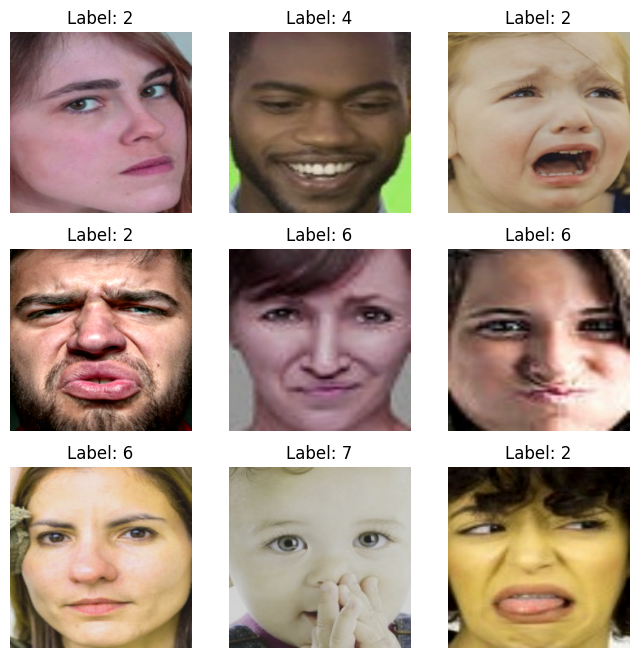

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images
images, labels = next(iter(train_loader))

# Convert images for visualization
images = images.numpy().transpose(0, 2, 3, 1)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images * std + mean
images = np.clip(images, 0, 1)

# Plot images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")

plt.show()
